In [56]:

import zipfile
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, auc, roc_curve, f1_score
from sklearn.feature_selection import mutual_info_classif, f_classif, SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from scipy import stats


In [57]:
# Run this to use from colab environment
with zipfile.ZipFile('ecg/ecg_data.zip', 'r') as zip_ref: #TODO: let hierop voor inleveren
    zip_ref.extractall('ecg')

data = pd.read_csv('ecg/ecg_data.csv', index_col=0)

print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

The number of samples: 827
The number of columns: 9001


In [61]:
# Splits features en labels
X = data.iloc[:, :-1].values  # Alle kolommen behalve de laatste zijn de features
y = data.iloc[:, -1].values   # De laatste kolom is de label (0 of 1)

In [62]:
def inner_cv_feature_selection_with_model_optimization(X_train, y_train, k_features=2100):

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    method_scores = {
        'ttest': {'normal': [], 'abnormal': []},
        'kbest': {'normal': [], 'abnormal': []},
        'rf': {'normal': [], 'abnormal': []},
        'mi': {'normal': [], 'abnormal': []}
    }

    def select_features(method, X_tr, y_tr):
        if method == 'ttest':
            p_values = [stats.ttest_ind(X_tr[y_tr == 0, i], X_tr[y_tr == 1, i])[1]
                        for i in range(X_tr.shape[1])]
            return np.argsort(p_values)[:k_features]
        elif method == 'kbest':
            skb = SelectKBest(score_func=f_classif, k=k_features)
            skb.fit(X_tr, y_tr)
            return skb.get_support(indices=True)
        elif method == 'rf':
            rf = RandomForestClassifier(n_estimators=100, random_state=42)
            rf.fit(X_tr, y_tr)
            return np.argsort(rf.feature_importances_)[-k_features:]
        elif method == 'mi':
            mi = mutual_info_classif(X_tr, y_tr)
            return np.argsort(mi)[-k_features:]

    for method in method_scores.keys():
        print(f"\n Evaluating Feature Selection: {method}")
        for train_idx, val_idx in skf.split(X_train, y_train):
            X_tr, X_val = X_train[train_idx], X_train[val_idx]
            y_tr, y_val = y_train[train_idx], y_train[val_idx]

            scaler = StandardScaler()
            X_tr = scaler.fit_transform(X_tr)
            X_val = scaler.transform(X_val)

            selected_idx = select_features(method, X_tr, y_tr)
            X_tr_sel = X_tr[:, selected_idx]
            X_val_sel = X_val[:, selected_idx]

            best_f1_normal = 0
            best_f1_abnormal = 0
            for depth in [5, 10, 20]:
                rf = RandomForestClassifier(max_depth=depth, n_estimators=100, random_state=42)
                rf.fit(X_tr_sel, y_tr)
                preds = rf.predict(X_val_sel)
                f1s = f1_score(y_val, preds, average=None, labels=[0, 1])
                best_f1_normal = max(best_f1_normal, f1s[0])
                best_f1_abnormal = max(best_f1_abnormal, f1s[1])

            method_scores[method]['normal'].append(best_f1_normal)
            method_scores[method]['abnormal'].append(best_f1_abnormal)

        # Summary per method
        f1_normal = np.mean(method_scores[method]['normal'])
        f1_abnormal = np.mean(method_scores[method]['abnormal'])
        print(f"Normal (0) F1:   {f1_normal:.4f}")
        print(f"Abnormal (1) F1: {f1_abnormal:.4f}")

    print("\n Summary of All Feature Selection Methods:")
    for method in method_scores.keys():
        n_avg = np.mean(method_scores[method]['normal'])
        a_avg = np.mean(method_scores[method]['abnormal'])
        print(f"{method:>10} → Normal F1: {n_avg:.4f} | Abnormal F1: {a_avg:.4f}")


In [63]:
# Step 1: Run feature selection + RF evaluation across inner folds
inner_cv_feature_selection_with_model_optimization(X, y)


 Evaluating Feature Selection: ttest
Normal (0) F1:   0.9206
Abnormal (1) F1: 0.3499

 Evaluating Feature Selection: kbest
Normal (0) F1:   0.9183
Abnormal (1) F1: 0.3054

 Evaluating Feature Selection: rf
Normal (0) F1:   0.9163
Abnormal (1) F1: 0.2762

 Evaluating Feature Selection: mi
Normal (0) F1:   0.9183
Abnormal (1) F1: 0.2949

 Summary of All Feature Selection Methods:
     ttest → Normal F1: 0.9206 | Abnormal F1: 0.3499
     kbest → Normal F1: 0.9183 | Abnormal F1: 0.3054
        rf → Normal F1: 0.9163 | Abnormal F1: 0.2762
        mi → Normal F1: 0.9183 | Abnormal F1: 0.2949


In [64]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

def outer_cv_pipeline_rf(X, y, feature_selection_method, k_features=2100):
    # Outer CV Split
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Randomized Search for Random Forest
    def random_search_rf(X_tr, y_tr):
        rf = RandomForestClassifier(random_state=42)
        param_dist = {
            'n_estimators': [100],
            'max_depth': [5],
            'min_samples_split': [2],
            'min_samples_leaf': [1],
        }
        random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=1, cv=3, random_state=42, n_jobs=-1)
        random_search.fit(X_tr, y_tr)
        return random_search.best_estimator_

    # Initialize lists to store results for each fold
    rf_results_normal = []
    rf_results_abnormal = []

    # Outer Cross-validation loop
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # --- Scale the data (fit on training, transform on both train/test) ---
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)  # Fit on training set
        X_test_scaled = scaler.transform(X_test)        # Use the same scaler for the test set

        # --- Feature Selection using the specified method ---
        selected_idx = feature_selection_method(X_train_scaled, y_train, k_features)
        X_train_sel = X_train_scaled[:, selected_idx]
        X_test_sel = X_test_scaled[:, selected_idx]
        
        # --- Inner Cross-validation (for model optimization using RandomizedSearchCV) ---
        skf_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        for inner_train_idx, inner_val_idx in skf_inner.split(X_train_sel, y_train):
            X_inner_train, X_inner_val = X_train_sel[inner_train_idx], X_train_sel[inner_val_idx]
            y_inner_train, y_inner_val = y_train[inner_train_idx], y_train[inner_val_idx]
            
            # RandomizedSearch for Random Forest
            rf_model = random_search_rf(X_inner_train, y_inner_train)

            # --- Train model and get F1 scores for normal (0) and abnormal (1) classes ---
            rf_preds = rf_model.predict(X_inner_val)

            # F1 scores for both classes (normal and abnormal)
            f1_rf = f1_score(y_inner_val, rf_preds, average=None, labels=[0, 1])

            # Store results for this fold
            rf_results_normal.append(f1_rf[0])
            rf_results_abnormal.append(f1_rf[1])
        
        # --- Final evaluation on the outer test set after optimization ---
        rf_model_final = random_search_rf(X_train_sel, y_train)
        rf_preds_test = rf_model_final.predict(X_test_sel)

        # F1 scores for Random Forest on outer test set
        f1_rf_test = f1_score(y_test, rf_preds_test, average=None, labels=[0, 1])

        # Print results for outer fold evaluation
        print(f"\nOuter Fold Evaluation Results for Random Forest:")
        print(f"Random Forest: Normal F1: {f1_rf_test[0]:.4f} | Abnormal F1: {f1_rf_test[1]:.4f}")

    # --- Final Summary after all outer folds ---
    print("\n Final Summary of All Outer Folds for Random Forest:")
    print(f"Random Forest: Average Normal F1: {np.mean(rf_results_normal):.4f} | Average Abnormal F1: {np.mean(rf_results_abnormal):.4f}")


In [65]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def outer_cv_pipeline_svm(X, y, feature_selection_method, k_features=2100):
    # Outer CV Split
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Randomized Search for SVM
    def random_search_svm(X_tr, y_tr):
        param_dist = {
            'C': [0.1, 1, 10, 100],
            'gamma': ['scale', 0.01, 0.1, 1],
            'kernel': ['rbf']
        }
        svm = SVC(probability=True, class_weight='balanced', random_state=42)
        search = RandomizedSearchCV(
            estimator=svm,
            param_distributions=param_dist,
            n_iter=3,
            cv=3,
            scoring='roc_auc',
            n_jobs=-1,
            verbose=0,
            random_state=42
        )
        search.fit(X_tr, y_tr)
        return search.best_estimator_

    # Initialize lists to store results for each fold
    svm_results_normal = []
    svm_results_abnormal = []

    # Outer Cross-validation loop
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # --- Scale the data (fit on training, transform on both train/test) ---
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)  # Fit on training set
        X_test_scaled = scaler.transform(X_test)        # Use the same scaler for the test set

        # --- Feature Selection using the specified method ---
        selected_idx = feature_selection_method(X_train_scaled, y_train, k_features)
        X_train_sel = X_train_scaled[:, selected_idx]
        X_test_sel = X_test_scaled[:, selected_idx]
        
        # --- Inner Cross-validation (for model optimization using RandomizedSearchCV) ---
        skf_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        fold = 1
        for inner_train_idx, inner_val_idx in skf_inner.split(X_train_sel, y_train):
            X_inner_train, X_inner_val = X_train_sel[inner_train_idx], X_train_sel[inner_val_idx]
            y_inner_train, y_inner_val = y_train[inner_train_idx], y_train[inner_val_idx]
            
            # RandomizedSearch for SVM
            svm_model = random_search_svm(X_inner_train, y_inner_train)

            # --- Train model and get F1 scores for normal (0) and abnormal (1) classes ---
            svm_preds = svm_model.predict(X_inner_val)

            # F1 scores for both classes (normal and abnormal)
            f1_svm = f1_score(y_inner_val, svm_preds, average=None, labels=[0, 1])

            # Store results for this fold
            svm_results_normal.append(f1_svm[0])
            svm_results_abnormal.append(f1_svm[1])
            
        
        # --- Final evaluation on the outer test set after optimization ---
        svm_model_final = random_search_svm(X_train_sel, y_train)
        svm_preds_test = svm_model_final.predict(X_test_sel)

        # F1 scores for SVM on outer test set
        f1_svm_test = f1_score(y_test, svm_preds_test, average=None, labels=[0, 1])

        # Confusion matrix
        cm = confusion_matrix(y_test, svm_preds_test)
        labels = ['Normal', 'Abnormal']
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Confusion Matrix - Fold {fold}')  # Optionally format with actual fold number
        plt.tight_layout()
        plt.show()

        # Print results for outer fold evaluation
        print(f"\nOuter Fold Evaluation Results for SVM:")
        print(f"SVM: Normal F1: {f1_svm_test[0]:.4f} | Abnormal F1: {f1_svm_test[1]:.4f}")

        fold += 1

    # --- Final Summary after all outer folds ---
    print("\n Final Summary of All Outer Folds for SVM:")
    print(f"SVM: Average Normal F1: {np.mean(svm_results_normal):.4f} | Average Abnormal F1: {np.mean(svm_results_abnormal):.4f}")


In [66]:
# Best feature selection method of inner cv is ttest
def ttest_selector(X, y, k):
    from scipy import stats
    import numpy as np
    p_values = [stats.ttest_ind(X[y == 0, i], X[y == 1, i])[1] for i in range(X.shape[1])]
    return np.argsort(p_values)[:k]


In [67]:
# Use Random Forest for evaluation
outer_cv_pipeline_rf(X, y, ttest_selector)


Outer Fold Evaluation Results for Random Forest:
Random Forest: Normal F1: 0.9164 | Abnormal F1: 0.2424

Outer Fold Evaluation Results for Random Forest:
Random Forest: Normal F1: 0.9097 | Abnormal F1: 0.1818

Outer Fold Evaluation Results for Random Forest:
Random Forest: Normal F1: 0.9189 | Abnormal F1: 0.2941

Outer Fold Evaluation Results for Random Forest:
Random Forest: Normal F1: 0.9220 | Abnormal F1: 0.3429

Outer Fold Evaluation Results for Random Forest:
Random Forest: Normal F1: 0.9067 | Abnormal F1: 0.0667

 Final Summary of All Outer Folds for Random Forest:
Random Forest: Average Normal F1: 0.9115 | Average Abnormal F1: 0.2004


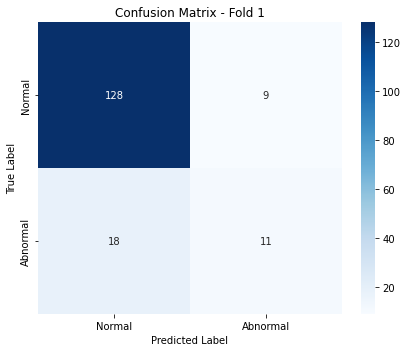


Outer Fold Evaluation Results for SVM:
SVM: Normal F1: 0.9046 | Abnormal F1: 0.4490


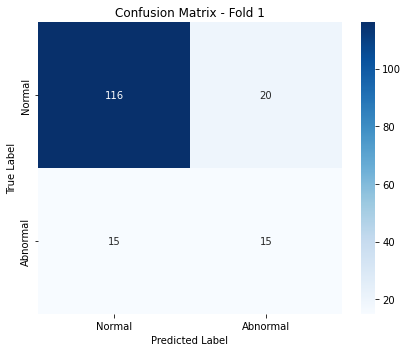


Outer Fold Evaluation Results for SVM:
SVM: Normal F1: 0.8689 | Abnormal F1: 0.4615


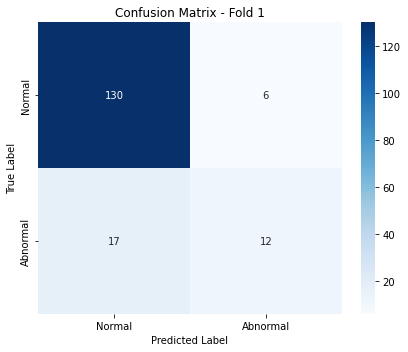


Outer Fold Evaluation Results for SVM:
SVM: Normal F1: 0.9187 | Abnormal F1: 0.5106


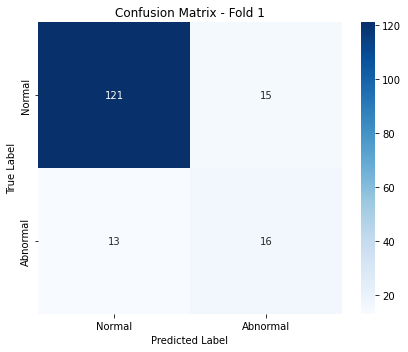


Outer Fold Evaluation Results for SVM:
SVM: Normal F1: 0.8963 | Abnormal F1: 0.5333


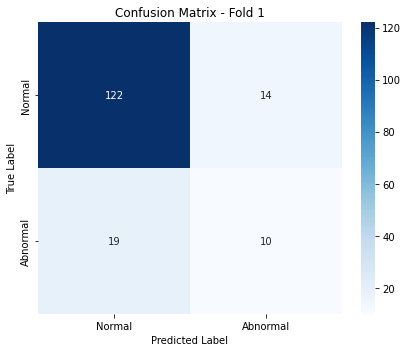


Outer Fold Evaluation Results for SVM:
SVM: Normal F1: 0.8809 | Abnormal F1: 0.3774

 Final Summary of All Outer Folds for SVM:
SVM: Average Normal F1: 0.8940 | Average Abnormal F1: 0.4461


In [68]:
# Use SVM for evaluation
outer_cv_pipeline_svm(X, y, ttest_selector)

In [ ]:
def outer_cv_pipeline_svm_flipped(X, y, feature_selection_method, k_features=2100):
    # Flip the labels: 1 = Normal, 0 = Abnormal
    y = 1 - y

    # Outer CV Split
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Randomized Search for SVM
    def random_search_svm(X_tr, y_tr):
        param_dist = {
            'C': [0.1, 1, 10, 100],
            'gamma': ['scale', 0.01, 0.1, 1],
            'kernel': ['rbf']
        }
        svm = SVC(probability=True, class_weight='balanced', random_state=42)
        search = RandomizedSearchCV(
            estimator=svm,
            param_distributions=param_dist,
            n_iter=1,
            cv=5,
            scoring='roc_auc',
            n_jobs=-1,
            verbose=0,
            random_state=42
        )
        search.fit(X_tr, y_tr)
        return search.best_estimator_

    svm_results_normal = []
    svm_results_abnormal = []
    fold = 1

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        selected_idx = feature_selection_method(X_train_scaled, y_train, k_features)
        X_train_sel = X_train_scaled[:, selected_idx]
        X_test_sel = X_test_scaled[:, selected_idx]

        svm_model = random_search_svm(X_train_sel, y_train)
        y_prob = svm_model.predict_proba(X_test_sel)[:, 1]  # Probability of being NORMAL
        threshold = 0.65
        y_pred_flipped = (y_prob >= threshold).astype(int)

        # Flip predictions and truth back for interpretation: 1 = Abnormal, 0 = Normal
        y_test_original = 1 - y_test
        y_pred_original = 1 - y_pred_flipped

        f1 = f1_score(y_test_original, y_pred_original, average=None, labels=[0, 1])
        svm_results_normal.append(f1[0])
        svm_results_abnormal.append(f1[1])

        cm = confusion_matrix(y_test_original, y_pred_original)
        labels = ['Normal', 'Abnormal']
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Confusion Matrix (Fold {fold})')
        plt.tight_layout()
        plt.show()

        fpr, tpr, _ = roc_curve(y_test_original, y_prob, pos_label=1)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve (Fold {fold})')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        print(f"\nOuter Fold {fold} Evaluation:")
        print(f"F1 - Normal: {f1[0]:.4f} | F1 - Abnormal: {f1[1]:.4f} | AUC: {roc_auc:.4f}")
        fold += 1

    print("\nFinal Summary of All Outer Folds:")
    print(f"Average F1 - Normal: {np.mean(svm_results_normal):.4f} | Average F1 - Abnormal: {np.mean(svm_results_abnormal):.4f}")


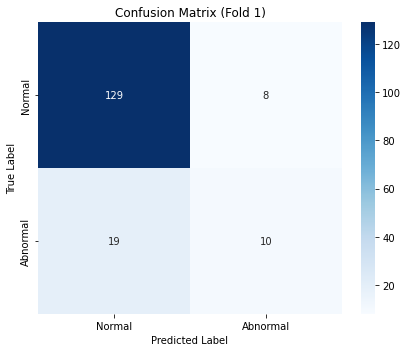

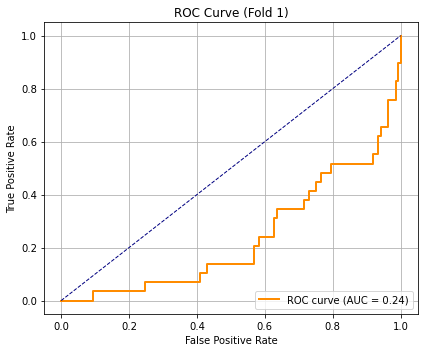


Outer Fold 1 Evaluation:
F1 - Normal: 0.9053 | F1 - Abnormal: 0.4255 | AUC: 0.2368


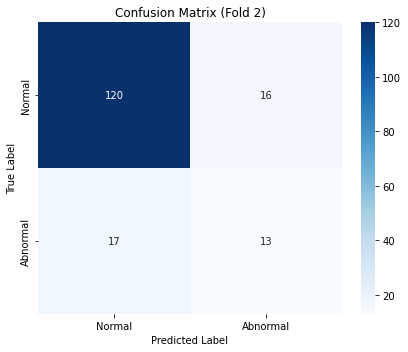

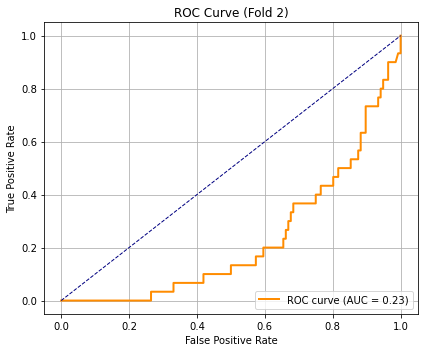


Outer Fold 2 Evaluation:
F1 - Normal: 0.8791 | F1 - Abnormal: 0.4407 | AUC: 0.2305


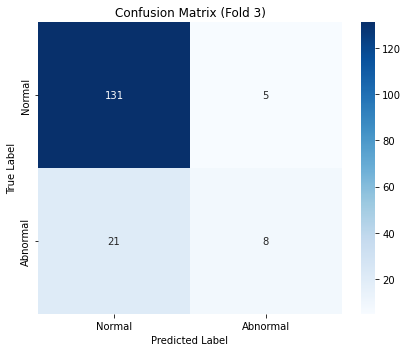

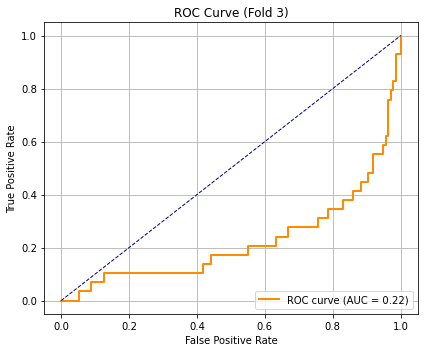


Outer Fold 3 Evaluation:
F1 - Normal: 0.9097 | F1 - Abnormal: 0.3810 | AUC: 0.2241


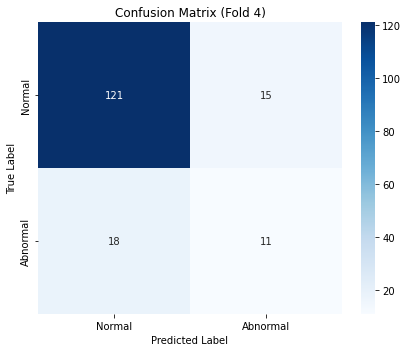

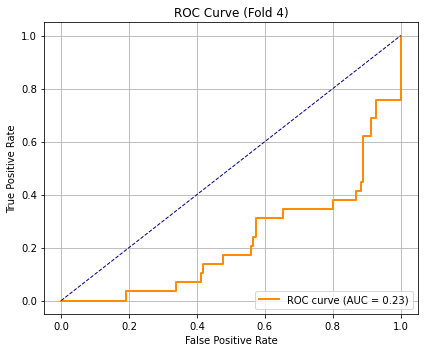


Outer Fold 4 Evaluation:
F1 - Normal: 0.8800 | F1 - Abnormal: 0.4000 | AUC: 0.2262


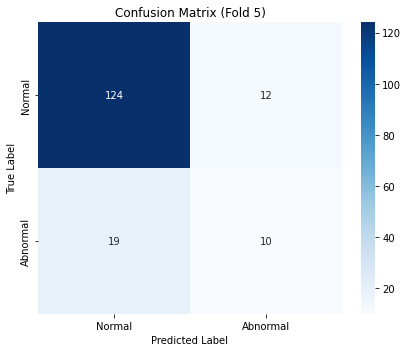

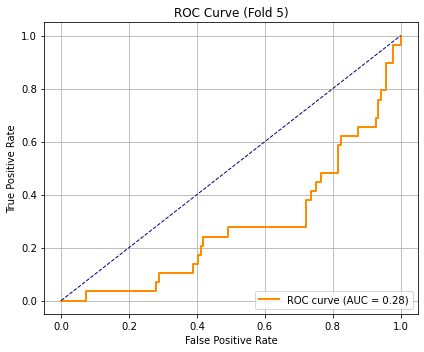


Outer Fold 5 Evaluation:
F1 - Normal: 0.8889 | F1 - Abnormal: 0.3922 | AUC: 0.2802

Final Summary of All Outer Folds:
Average F1 - Normal: 0.8926 | Average F1 - Abnormal: 0.4079


In [73]:
outer_cv_pipeline_svm_flipped(X, y, ttest_selector)